# EMO task

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dependencies

In [2]:
!pip install transformers -q
!pip install accelerate -U -q
!pip install datasets -q
!pip install torch-summary -q
!pip install graphviz -q
!pip install torchview -q
!pip install bertviz -q
!pip install NRCLex -q
!pip install textblob -q
!python -m textblob.download_corpora -q

repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "irene_from_main"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

--2023-07-09 19:29:33--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/irene_from_main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27197 (27K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  26.56K  --.-KB/s    in 0.002s  

2023-07-09 19:29:33 (17.0 MB/s) - ‘utils.py’ saved [27197/27197]

--2023-07-09 19:29:34--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/irene_from_main/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [4]:
import json
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
import importlib
import sys
from utils import *
importlib.reload(sys.modules['utils'])

<module 'utils' from '/content/utils.py'>

In [5]:
# set CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")

======= CUDA Available =======


## Model

In [6]:
NUM_LABELS = 8

model_config = {
    'model_id': 'bert_baseline',
    'tokenizer_name': 'bert-base-cased',
    'model_name': 'bert-base-cased',
    'train_batch_size': 4,
    'val_batch_size': 4,
    'learning_rate': 5e-5,
    'weight_decay': 0,
    'epochs': 10,
    'seed': 42,
    'patience': 10,
    'early_stopping_threshold': 0
} # TODO: expand...

tokenizer = AutoTokenizer.from_pretrained(model_config['tokenizer_name'], truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_config['model_name'],
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Dataset

Dataset paths

In [7]:
TRAIN_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_internal_train_preproc.tsv"
VAL_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_internal_val_preproc.tsv"
DEV_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_dev_preproc.tsv"

Read dataframes

In [8]:
train_df = pd.read_csv(TRAIN_DATA, sep='\t')
val_df = pd.read_csv(VAL_DATA, sep='\t')
full_train_df = pd.concat([train_df, val_df], ignore_index = True)
dev_df = pd.read_csv(DEV_DATA, sep='\t')

In [9]:
from nrclex import NRCLex

def generate_only_prompt(essay, gender, education, ethnicity, age, income, empathy, distress):
    if gender == 1: gender_str = "male"
    else: gender_str = "female"

    if education == 1: education_str = "with less than a high school diploma"
    elif education == 2: education_str = "with a high school diploma"
    elif education == 3: education_str = "went to a technical/vocational school"
    elif education == 4: education_str = "went to college"
    elif education == 5: education_str = "with a two year associate degree"
    elif education == 6: education_str = "with a four year bachelor's degree"
    else: education_str = "postgradute or with a professional degree"

    if ethnicity == 1: ethnicity_str = " white"
    elif ethnicity == 2: ethnicity_str = " hispanic or latino"
    elif ethnicity == 3: ethnicity_str = " black or african american"
    elif ethnicity == 4: ethnicity_str = " native american or american indian"
    elif ethnicity == 5: ethnicity_str = " asian/pacific islander"
    else: ethnicity_str = ""

    text_prompt_bio = "An essay written by a {} years old{} {}, {}, with an income of {}$.".format(
        age, ethnicity_str,
        gender_str,
        education_str,
        income
        )

    if empathy is not None:
        if empathy < 3: empathy_value = "low"
        elif empathy < 5: empathy_value = "medium"
        else: empathy_value = "high"
        if distress < 3: distress_value = "low"
        elif distress < 5: distress_value = "medium"
        else: distress_value = "high"
        text_prompt_emp = "The essay expresses {} empathy and {} distress levels.".format(
            empathy_value,
            distress_value
            )

    emotions = NRCLex(essay).top_emotions
    if (sum(np.array([emo[1] for emo in emotions])))==0:
        emotions = {'neutral': 1}
    n_emo = len(emotions)
    emo_string = ""
    for i, emo in enumerate(emotions):
        emo_string += emo[0]
        if i < n_emo-1:
            emo_string += ", "
    text_prompt_emo = " The top emotions expressed in the essay are: {}.".format(emo_string)

    text_prompt = text_prompt_bio + text_prompt_emp + text_prompt_emo
    return text_prompt

def add_only_prompt(dataframe, empathy=True):
    dataframe["prompt_alone"] = ""
    for idx, row in dataframe.iterrows():
        text_prompt = generate_only_prompt(
            row['essay'],
            row['gender'],
            row['education'],
            row['race'],
            row['age'],
            row['income'],
            row['empathy'] if empathy else None,
            row['distress'] if empathy else None
            )
        dataframe["prompt_alone"][idx] = text_prompt
    return dataframe

In [10]:
train_df

,conversation_id,article_id,essay,empathy,distress,speaker_id,gender,education,race,age,...,anger_count,disgust_count,fear_count,joy_count,sadness_count,surprise_count,hope_count,empathy_count,distress_count,prompt
0,193,313,It's so sad the turning event of Immigrants st...,6.333333,6.125,36,1,7,1,46,...,6.896552,3.448276,10.344828,5.172414,15.517241,3.448276,0,8.220577,7.137115,It's so sad the turning event of Immigrants st...
1,340,223,I feel bad for the mother and her two daughter...,6.500000,2.875,30,1,6,3,37,...,9.230769,7.692308,18.461538,15.384615,24.615385,12.307692,0,6.851257,6.467713,I feel bad for the mother and her two daughter...
2,392,270,I feel so bad for the victims and the victims ...,6.000000,6.000,53,2,3,1,27,...,8.943089,8.130081,10.569106,9.756098,9.756098,8.130081,0,3.762797,3.606506,I feel so bad for the victims and the victims ...
3,304,347,"One of the biggest fears of a parent, is that ...",6.666667,6.375,30,1,6,3,37,...,2.597403,1.298701,3.896104,19.480519,10.389610,6.493506,0,6.110432,5.607771,"One of the biggest fears of a parent, is that ..."
4,263,34,I feel sorry for the people living in that reg...,6.666667,6.625,30,1,6,3,37,...,4.411765,4.411765,10.294118,14.705882,7.352941,10.294118,0,6.668359,6.151027,I feel sorry for the people living in that reg...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,266,47,Reading about the situation in Syria is always...,4.000000,3.125,25,1,4,1,29,...,3.125000,0.000000,7.812500,3.125000,3.125000,0.000000,0,7.022593,6.635832,Reading about the situation in Syria is always...
613,319,39,I just read about an unfortunate wolf that had...,5.833333,4.750,25,1,4,1,29,...,10.169492,8.474576,8.474576,1.694915,11.864407,5.084746,0,7.559620,7.106100,I just read about an unfortunate wolf that had...
614,419,301,I had to read this article over twice because ...,6.166667,6.000,19,1,6,2,32,...,4.285714,2.857143,2.857143,7.142857,5.714286,5.714286,0,6.532548,6.238817,I had to read this article over twice because ...
615,479,53,I just read an article about the amount of foo...,1.000000,2.625,25,1,4,1,29,...,2.898551,2.898551,1.449275,8.695652,4.347826,0.000000,0,5.986728,5.726251,I just read an article about the amount of foo...


In [11]:
train_df = add_only_prompt(train_df, empathy=True)
val_df = add_only_prompt(val_df, empathy=True)
full_train_df = add_only_prompt(full_train_df, empathy=True)
dev_df = add_only_prompt(dev_df, empathy=True)

<ipython-input-9-65780bec528e>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["prompt_alone"][idx] = text_prompt
<ipython-input-9-65780bec528e>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["prompt_alone"][idx] = text_prompt
<ipython-input-9-65780bec528e>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["prompt_alone"][idx] = text_prompt
<ipython-input-9-65780bec528e>:68: SettingWithCopyWarning: 
A

Encode targets

In [12]:
label_encoder = EmotionsLabelEncoder()
label_encoder.fit(train_df.emotion)

In [13]:
y_train = label_encoder.encode(train_df.emotion)
y_val = label_encoder.encode(val_df.emotion)
full_y_train = np.concatenate((y_train, y_val))

y_dev = label_encoder.encode(dev_df.emotion)

In [14]:
train_df.emotion

0          Hope/Sadness
1          Hope/Sadness
2          Hope/Sadness
3          Hope/Sadness
4          Hope/Sadness
             ...       
612    Sadness/Surprise
613    Disgust/Surprise
614    Disgust/Surprise
615    Disgust/Surprise
616          Anger/Hope
Name: emotion, Length: 617, dtype: object

In [15]:
class EMOSEPDataset(Dataset):
    '''
    This class is used to create a pytorch dataset for the EMO task.
    '''

    def __init__(
        self,
        tokenizer,
        essay,
        targets,
        sep=False,
        prompt=None,
        features=None, # additional numerical features (n_features for each sample)
        max_len=None
        ):
        self.tokenizer = tokenizer
        self.essay = essay
        self.targets = targets
        self.sep = sep
        self.prompt = prompt
        self.features = features
        self.max_len = max_len

    def __len__(self):
        return len(self.essay) # TODO: a cosa serve??

    def __getitem__(self, index):
        essay = str(self.essay[index])
        prompt = str(self.prompt[index])
        if self.sep:
          text = essay
          text_pair = prompt
        else:
          text = essay + " " + prompt
          text_pair = None

        inputs = self.tokenizer.encode_plus(
            text=text,
            text_pair=text_pair,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
            return_token_type_ids=True
        )

        item = {
          'input_ids': inputs['input_ids'].flatten(),
          'attention_mask': inputs['attention_mask'].flatten(),
          'token_type_ids': inputs["token_type_ids"].flatten()
        }
        if self.features is not None:
          item['features'] = torch.FloatTensor(self.features[index])
        if self.targets is not None:
            item['labels'] = torch.FloatTensor(self.targets[index])
        return item

Prepare datasets

In [16]:
train_set = EMOSEPDataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train, sep=True, prompt=train_df.prompt)
val_set = EMOSEPDataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val, sep=True, prompt=val_df.prompt)
full_train_set = EMOSEPDataset(tokenizer=tokenizer, essay=full_train_df.essay, targets=full_y_train, sep=True, prompt=full_train_df.prompt)
dev_set = EMOSEPDataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev, sep=True, prompt=dev_df.prompt)

Optional subsample

In [17]:
train_df = train_df[:20]
val_df = val_df[:10]
dev_df = dev_df[:10]

## Training

Set up training

In [18]:
train_arguments = TrainingArguments(
    output_dir=f"./{model_config['model_name']}",
    per_device_train_batch_size=model_config['train_batch_size'],
    per_device_eval_batch_size=model_config['val_batch_size'],
    num_train_epochs=model_config['epochs'],
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=model_config['learning_rate'],
    weight_decay=model_config['weight_decay'],
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=model_config['seed'],
    logging_strategy = "epoch"
) # TODO: custom other params

trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=full_train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_EMO_metrics_trainer
)

Callbacks

In [19]:
class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=model_config['patience'],
    early_stopping_threshold=model_config['early_stopping_threshold']))
trainer.add_callback(TrainerLoggingCallback(model_config['model_id']+"_log.json"))

Start training

In [20]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Sklearn Accuracy,Roc Auc Micro,Accuracy,Micro Precision,Micro Recall,Micro F,Macro Precision,Macro Recall,Macro F
1,0.329600,0.291399,0.339506,0.668749,0.323944,0.793103,0.353846,0.489362,0.099138,0.115000,0.106481


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2035 in _inner_training_loop     │
│                                                                                                  │
│   2032 │   │   │   │   self.control.should_training_stop = True                                  │
│   2033 │   │   │                                                                                 │
│   2034 │   │   │   self.control = self.callback_handler.on_epoch_end(args, self.state, self.con  │
│ ❱ 2035 │   │   │   self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_  │
│   2036 │   │   │                                                                                 │
│   2037 │   │   │   if DebugOption.TPU_METRICS_DEBUG in self.args.debug:                          │
│   2038 │   │   │   │   if is_torch_tpu_available():                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2332 in _maybe_log_save_evaluate │
│                                                                                                  │
│   2329 │   │   │   │   self.lr_scheduler.step(metrics[metric_to_check])                          │
│   2330 │   │                                                                                     │
│   2331 │   │   if self.control.should_save:                                                      │
│ ❱ 2332 │   │   │   self._save_checkpoint(model, trial, metrics=metrics)                          │
│   2333 │   │   │   self.control = self.callback_handler.on_save(self.args, self.state, self.con  │
│   2334 │                                                                                         │
│   2335 │   def _load_rng_state(self, checkpoint):                                                │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2432 in _save_checkpoint         │
│                                                                                                  │
│   2429 │   │   │   if self.fsdp:                                                                 │
│   2430 │   │   │   │   torch.save(full_osd, os.path.join(output_dir, OPTIMIZER_NAME))            │
│   2431 │   │   │   else:                                                                         │
│ ❱ 2432 │   │   │   │   torch.save(self.optimizer.state_dict(), os.path.join(output_dir, OPTIMIZ  │
│   2433 │   │   │                                           

In [ ]:
# Access the training logs
train_logs = trainer.state.log_history

# Extract the loss values from the logs
train_loss_values = [log.get('loss') for log in train_logs if log.get('loss') is not None]
eval_loss_values = [log.get('eval_loss') for log in train_logs if log.get('eval_loss') is not None]

In [ ]:
train_loss_values

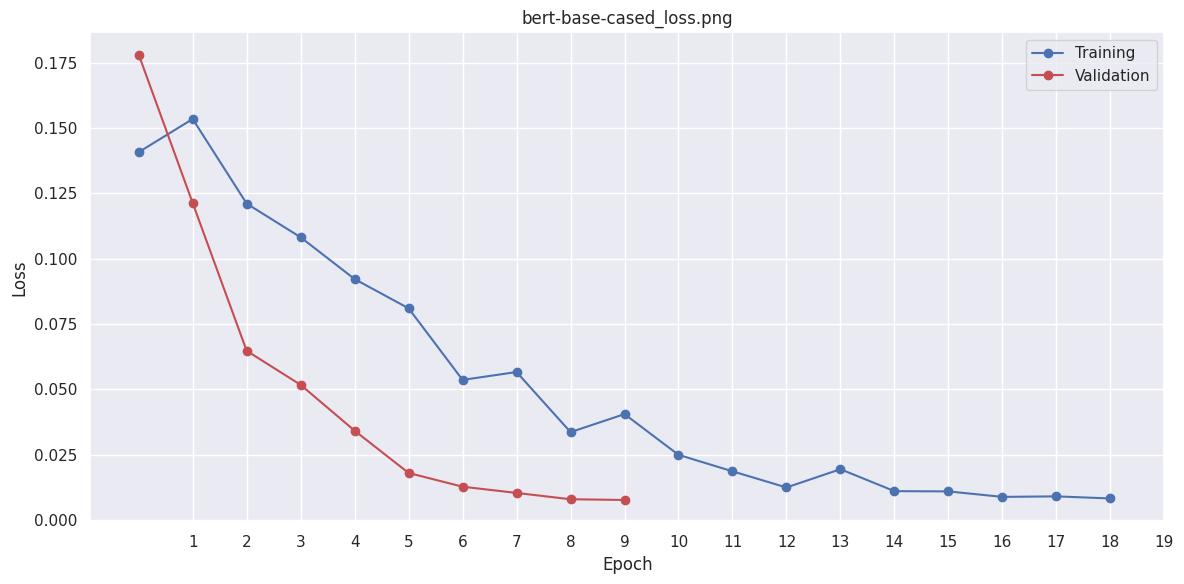

In [ ]:
plot_loss_curve(train_loss_values, eval_loss_values, "loss", f"{model_config['model_name']}_loss.png")

## Evaluation

In [ ]:
trainer.state.best_model_checkpoint

'./bert-base-cased/checkpoint-1980'

In [ ]:
results = trainer.predict(dev_set)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
gold_emotions = label_encoder.decode(results.label_ids)
binarized_predictions = np.where(results.predictions >= 0.5, 1, 0)
for i, bin_pred in enumerate(binarized_predictions):
  if np.all(bin_pred==0):
    binarized_predictions[i][np.argmax(results.predictions[i])] = 1
    # alternatively set the 'Neutral' emotion (cannot do it in compute_EMO_metrics_trainer)
    # binarized_predictions[i] = label_encoder.encode(['Neutral'])[0]
predicted_emotions = label_encoder.decode(binarized_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'micro_recall': 0.6545,
 'micro_precision': 0.694,
 'micro_f': 0.6736,
 'macro_recall': 0.4048,
 'macro_precision': 0.4676,
 'macro_F': 0.4283,
 'accuracy': 0.5079}

In [ ]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics

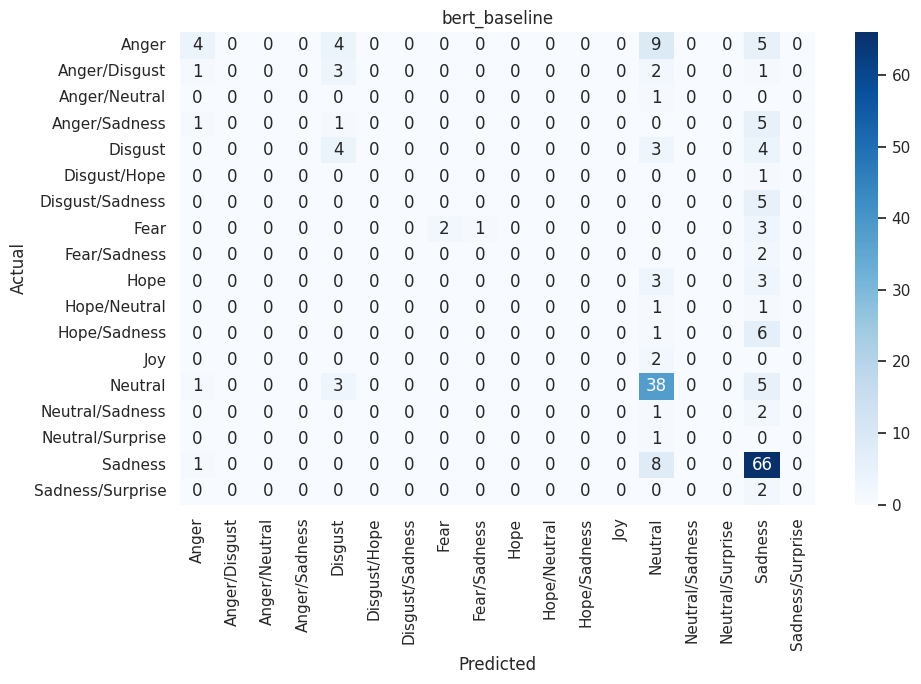

In [ ]:
plot_confusion_matrix(golds=gold_emotions, predictions=predicted_emotions, path=model_config['model_id']+"_confusion_matrix.pdf", title=model_config['model_id'])

In [ ]:
plot_model_graph(model=model, input_data=tokenizer("Hello world!", return_tensors="pt"), path=model_config['model_id']+"_graph")

In [ ]:
print_model_summary(model=model, path=model_config['model_id']+"_summary.txt")

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               22,268,928
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            6,152
Total params: 108,316,424
Trainable params: 108,316,424
Non-trainable params: 0


## Save model on Google Drive

In [ ]:
trainer.state.best_model_checkpoint

'./bert-base-cased/checkpoint-1980'

In [ ]:
!mv $trainer.state.best_model_checkpoint /content/drive/MyDrive/hlt

## Inference

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/hlt/best-roberta"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")